--- Initial Data Inspection ---
First 5 rows:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport St

/tmp/ipython-input-1762163631.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(0, inplace=True)


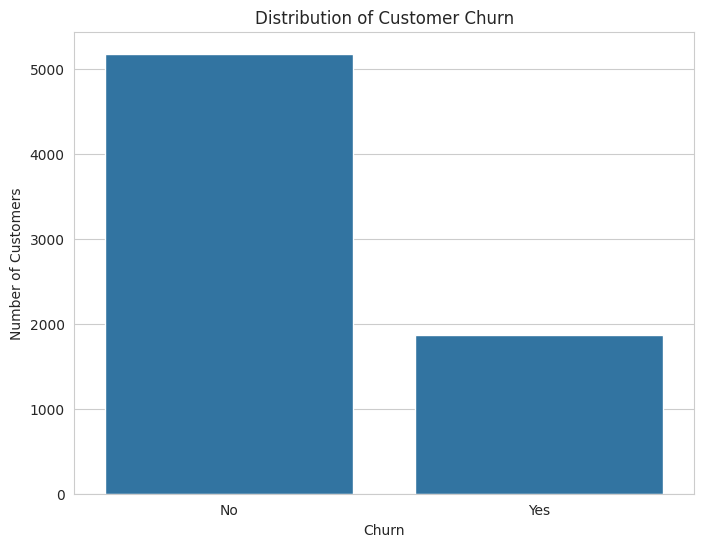


Percentage of Customer Churn:
Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


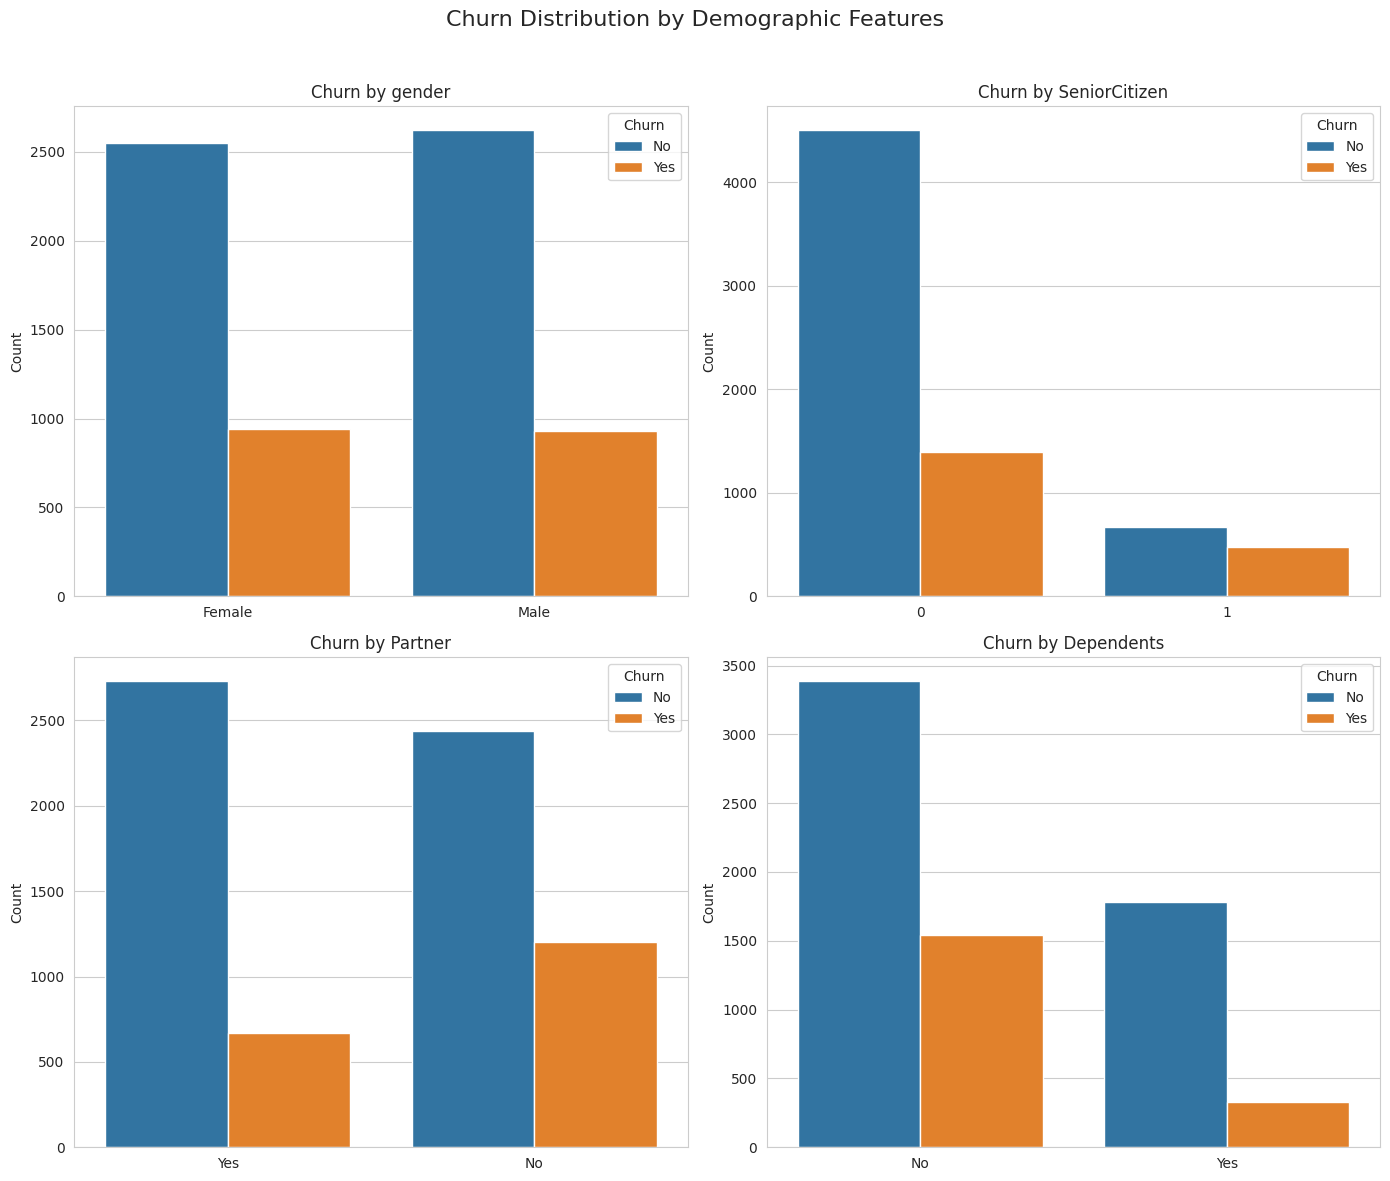

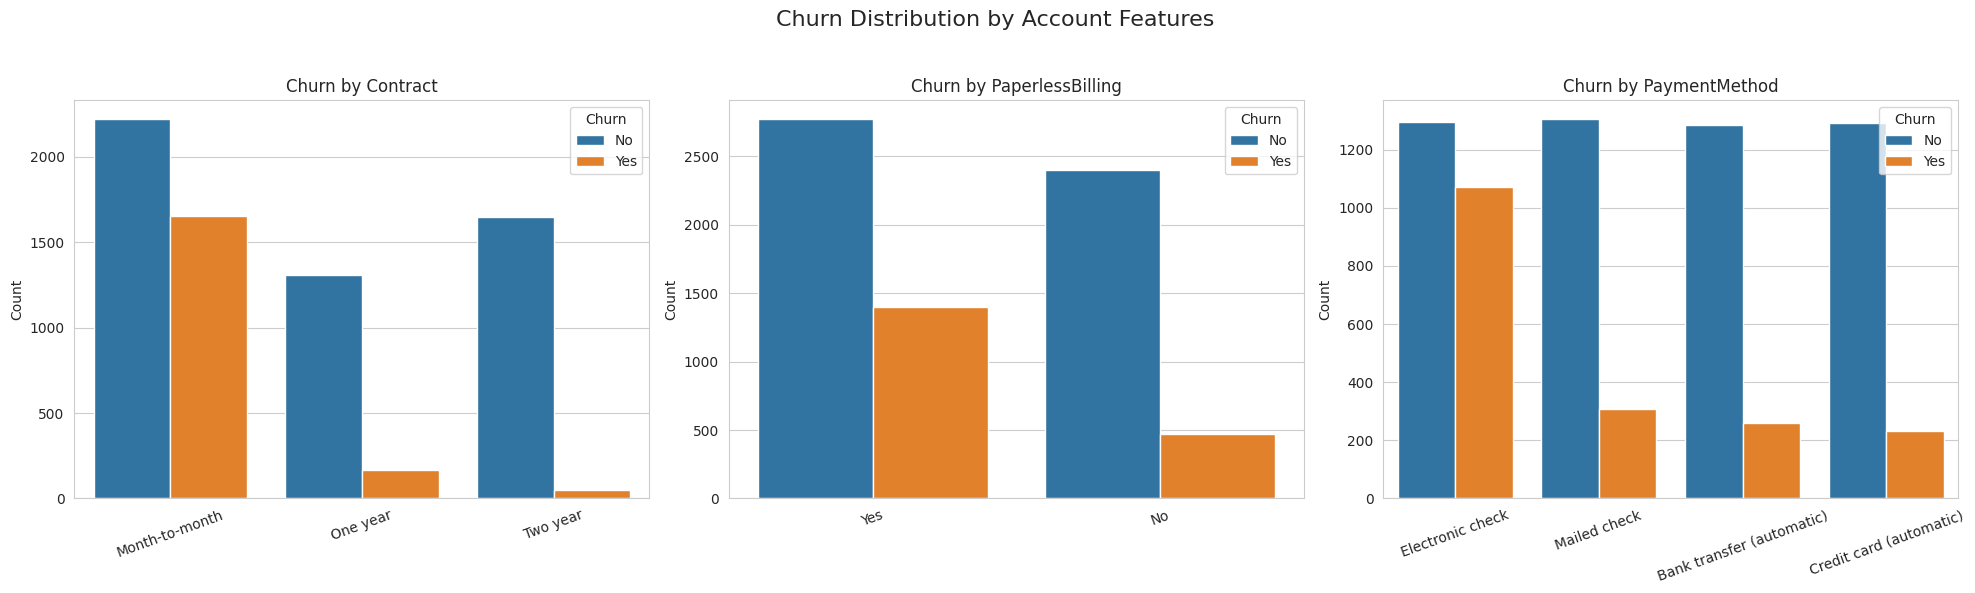

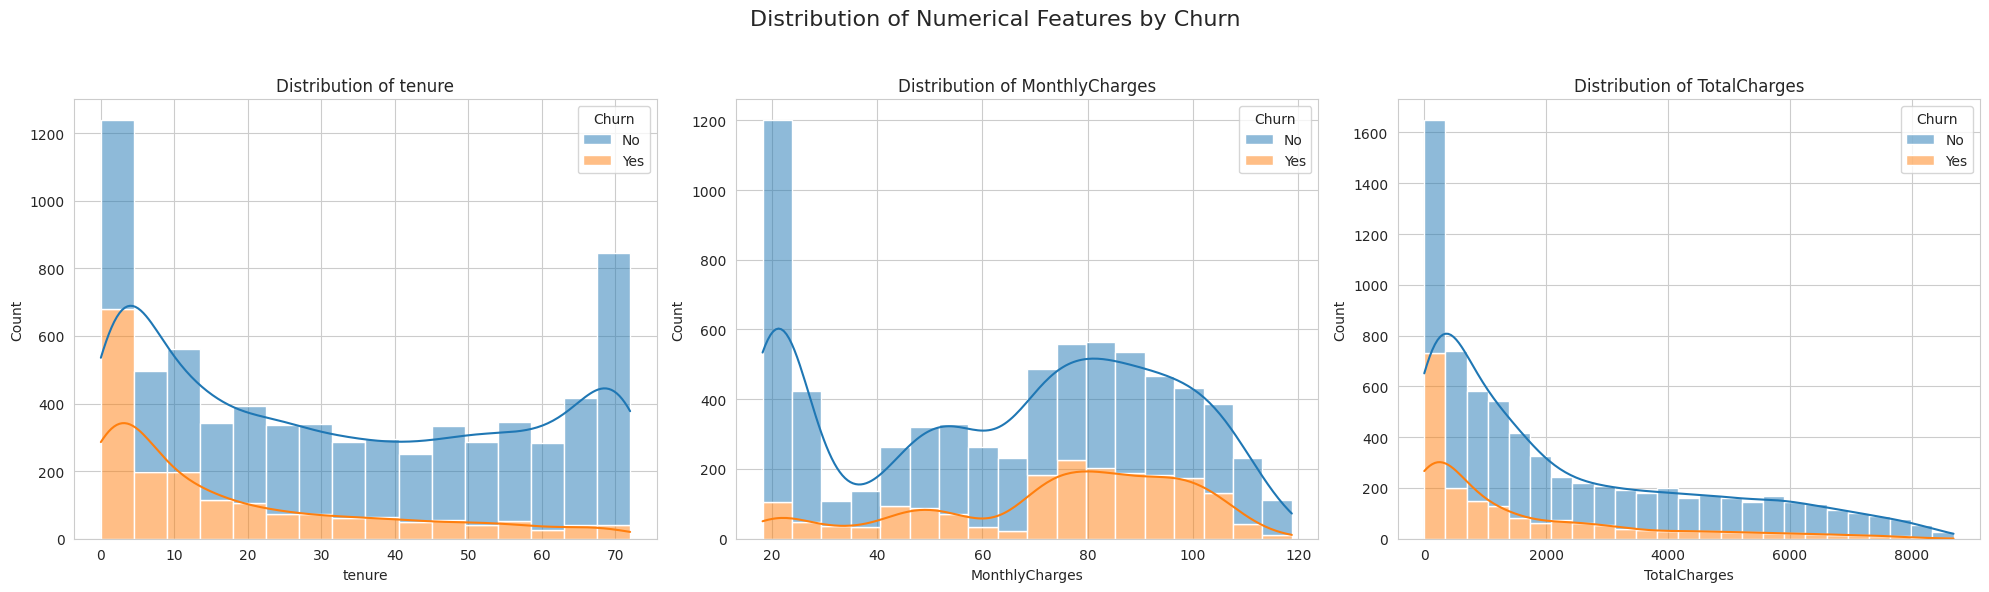


--- Data Split ---
X_train shape: (5634, 30)
X_test shape: (1409, 30)

Numerical features scaled.

Class distribution after SMOTE on training data:
Churn
0    4139
1    4139
Name: count, dtype: int64
Training Logistic Regression...
Training Random Forest...
Training Gradient Boosting...

--- Model Training Complete ---

--- Model Performance Comparison ---
                     Accuracy  Precision    Recall  F1-Score   ROC AUC
Logistic Regression  0.739532   0.506692  0.708556  0.590858  0.821207
Random Forest        0.762243   0.546099  0.617647  0.579674  0.817607
Gradient Boosting    0.748758   0.518315  0.756684  0.615217  0.838545


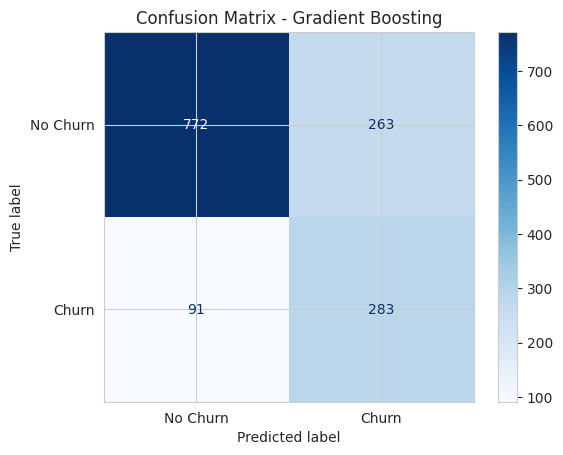

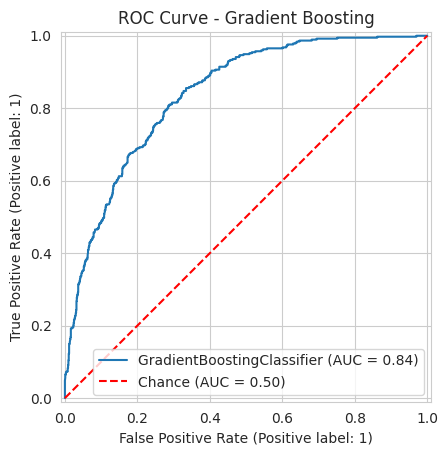

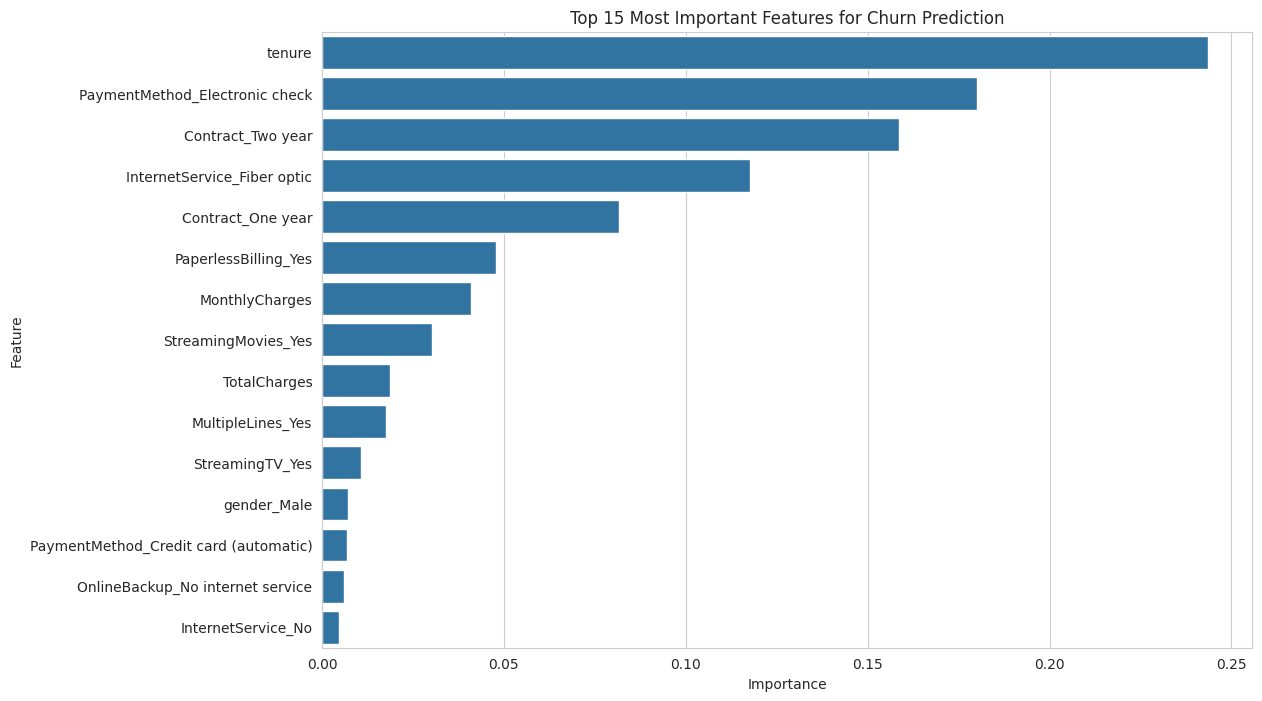

In [5]:
# --- CELL 1: Imports and Setup ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             ConfusionMatrixDisplay, RocCurveDisplay)

# Set plot style
sns.set_style('whitegrid')

# --- CELL 2: Data Loading and Initial Inspection ---
# --- Give correct path of thr csv file, or upload the csv file in the jupyter notebook.
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

print("--- Initial Data Inspection ---")
print("First 5 rows:")
print(df.head())
print("\nDataset Info:")
df.info()

# --- CELL 3: Data Cleaning ---
# Convert 'TotalCharges' to numeric, coercing errors to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Impute missing TotalCharges for new customers (tenure=0) with 0
df['TotalCharges'].fillna(0, inplace=True)

# Drop the customerID column as it's not needed for modeling
df.drop('customerID', axis=1, inplace=True)

print("\n--- Data Cleaning Complete ---")
print("Missing values after cleaning:")
print(df.isnull().sum())

# --- CELL 4: EDA - Churn Distribution ---
plt.figure(figsize=(8, 6))
sns.countplot(x='Churn', data=df)
plt.title('Distribution of Customer Churn')
plt.xlabel('Churn')
plt.ylabel('Number of Customers')
plt.show()

churn_percentage = df['Churn'].value_counts(normalize=True) * 100
print("\nPercentage of Customer Churn:")
print(churn_percentage)

# --- CELL 5: EDA - Demographics ---
demographic_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))
fig.suptitle('Churn Distribution by Demographic Features', fontsize=16)
for i, col in enumerate(demographic_cols):
    row, a_col = i // 2, i % 2
    sns.countplot(x=col, hue='Churn', data=df, ax=axes[row, a_col])
    axes[row, a_col].set_title(f'Churn by {col}')
    axes[row, a_col].set_xlabel('')
    axes[row, a_col].set_ylabel('Count')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# --- CELL 6: EDA - Account & Contract Features ---
account_cols = ['Contract', 'PaperlessBilling', 'PaymentMethod']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
fig.suptitle('Churn Distribution by Account Features', fontsize=16)
for i, col in enumerate(account_cols):
    sns.countplot(x=col, hue='Churn', data=df, ax=axes[i])
    axes[i].set_title(f'Churn by {col}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# --- CELL 7: EDA - Numerical Features ---
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
fig.suptitle('Distribution of Numerical Features by Churn', fontsize=16)
for i, col in enumerate(numerical_cols):
    sns.histplot(data=df, x=col, hue='Churn', multiple='stack', ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {col}')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# --- CELL 8: Preprocessing - Encoding and Splitting ---
# Separate features and target
X = df.drop('Churn', axis=1)
y = df['Churn'].map({'No': 0, 'Yes': 1})

# Identify categorical and numerical columns for processing
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Apply one-hot encoding
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("\n--- Data Split ---")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

# --- CELL 9: Preprocessing - Scaling and SMOTE ---
# Scale numerical features
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])
print("\nNumerical features scaled.")

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\nClass distribution after SMOTE on training data:")
print(y_train_resampled.value_counts())

# --- CELL 10: Model Training ---
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42, n_estimators=100)
}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_resampled, y_train_resampled)
print("\n--- Model Training Complete ---")

# --- CELL 11: Model Evaluation ---
results = {}
for name, model in models.items():
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    results[name] = [
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred),
        roc_auc_score(y_test, y_pred_proba)
    ]

results_df = pd.DataFrame.from_dict(results, orient='index',
                                    columns=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC'])

print("\n--- Model Performance Comparison ---")
print(results_df)

# --- CELL 12: Best Model Analysis - Confusion Matrix ---
best_model = models["Gradient Boosting"]
y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Churn', 'Churn'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Gradient Boosting')
plt.show()

# --- CELL 13: Best Model Analysis - ROC Curve ---
RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.title('ROC Curve - Gradient Boosting')
plt.plot([0, 1], [0, 1], 'r--', label='Chance (AUC = 0.50)')
plt.legend()
plt.show()

# --- CELL 14: Feature Importance ---
importances = best_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15))
plt.title('Top 15 Most Important Features for Churn Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()